In [5]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from callback import data_processing

import itertools

# 正規化
from sklearn.preprocessing import MinMaxScaler
import math

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Processing

In [6]:
def mk_dataframe(path):
    df = pd.read_table(path, sep=" ", header=None)
    df = df.drop(columns=0, axis=1)
    df = df.drop(columns=df.shape[1], axis=1)
    return df

df = mk_dataframe("230728/pos-3.dat")

In [7]:
df_ = df.values

In [8]:
df_.shape

(36000, 60)

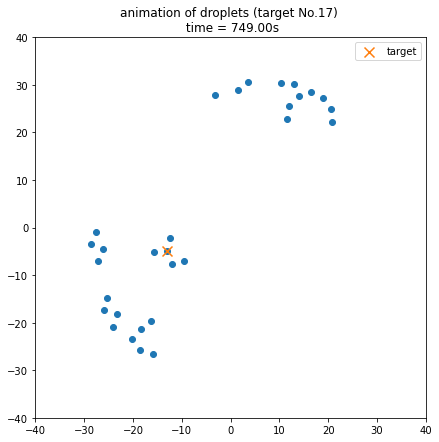

In [72]:
fig = plt.figure(figsize=(7,7))

start_time = 0
target = 17
def plot(time):
    plt.cla()                   # 前のグラフを削除
    
    time *= 10
    plt.scatter(df_[time+start_time,::2], df_[time+start_time,1::2])
    plt.scatter(df_[time+start_time,target*2], df_[time+start_time, target*2 + 1], marker="x", s=100, label = "target")
    plt.title("animation of droplets (target No.{}) \n time = {:.2f}s".format(target, (time+start_time) * 0.1))
    plt.legend()
    plt.xlim(-40,40)
    plt.ylim(-40,40)

    return fig

ani = animation.FuncAnimation(fig, plot, frames=750, interval=100)

from IPython.display import HTML
HTML(ani.to_html5_video())

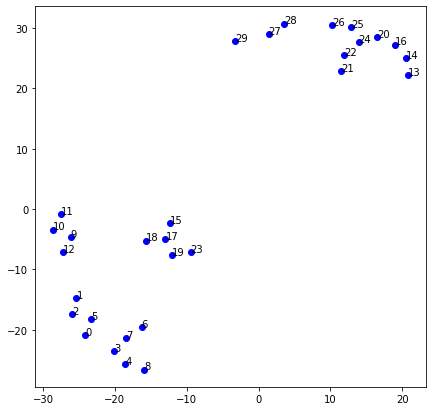

In [70]:
plt.figure(figsize=(7,7))
for i in range(30):
    plt.scatter(df_[7490,i*2], df_[7490,i*2+1], color="b")
    plt.text(df_[7490,i*2], df_[7490,i*2+1], i)

In [16]:
df_to_use = df_[:7500]

In [103]:
n_nearest_neighbors = 4
data = data_processing.DataProcessing(df_to_use, n_nearest_neighbors=4, target_no=17, split_angle=45)

In [104]:
labels, data_d_and_angle = data()

In [105]:
labels

array([6., 5., 1., ..., 2., 1., 6.])

### Labels and their size

In [106]:
np.unique(labels, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 array([1041,  942,  800,  848,  870,  936,  933, 1026,  102]))

#### Normalize data

In [107]:
# 距離を正規化
data_d_and_angle[:, ::4] /= 6
# 角度による標準化
data_d_and_angle[:, 1::4] /= 360

In [108]:
data_d_and_angle[0]

array([ 0.46376922,  0.99723196,  0.01773134, -0.01432463,  0.46455271,
        0.65979715, -0.0074878 , -0.01613582,  0.47120136,  0.39456615,
       -0.00315036, -0.01827883,  0.78611649,  0.30685409, -0.03146914,
       -0.04667295])

In [109]:
np.max(data_d_and_angle[:,::4])

0.9369265080286769

### Create Dataset and DataLoader

In [110]:
X = torch.tensor(data_d_and_angle, dtype=torch.float32)
target = torch.tensor(labels, dtype=torch.int64) 

# 目的変数と入力変数をまとめてdatasetに変換
dataset = torch.utils.data.TensorDataset(X,target)

# 各データセットのサンプル数を決定
# train : val : test = 80% : 10% : 10%
n_train = int(len(dataset) * 0.8)
n_val = int((len(dataset) - n_train) * 0.5)
n_test = len(dataset) - n_train - n_val

# データセットの分割
torch.manual_seed(0) #乱数を与えて固定
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val,n_test])

In [111]:
#バッチサイズ
batch_size = 100

# 乱数のシードを固定して再現性を確保
torch.manual_seed(0)

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

# 辞書型変数にまとめる(trainとvalをまとめて出す)
dataloaders_dict = {"train": train_loader, "val": val_loader}

## Model Define

In [112]:
class Net(nn.Module):

    # 使用するオブジェクトを定義
    def __init__(self, n_nearest_neighbors):
        super(Net, self).__init__()
        self.input_dim = n_nearest_neighbors * 4
        
        self.layers1 = nn.Sequential(
            nn.Linear(self.input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU()
        )
        self.layers2 = nn.Sequential(
            nn.Dropout(p=0.3, inplace=False),
            nn.BatchNorm1d(200),
            nn.Linear(200, 9)
        )

    # 順伝播
    def forward(self, x):
        
        x = self.layers1(x)
        out = self.layers2(x)
        return out    

In [113]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Clear the gradients
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss /= len(train_loader)
    accuracy = 100.0 * correct / total
    
    return train_loss, accuracy


def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_loss /= len(test_loader)
    accuracy = 100.0 * correct / total
    
    return test_loss, accuracy


## Train

In [116]:
# インスタンス化
net = Net(n_nearest_neighbors=4)

# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# 最適化手法の選択
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

epochs = 1000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [117]:
loss = {
    "train": [],
    "val": []
}

for i in range(epochs):
    train_loss, train_acc = train(net, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(net, val_loader, criterion, device)
    
    loss["train"].append(train_loss)
    loss["val"].append(val_loss)
    
    if i == 0 or (i+1) % 100 == 0:
        print("epoch: {:>3}, train_loss: {:.4f}, train_acc: {:.2f}%, val_loss: {:.4f}, val_acc: {:.2f}%".format(
            i+1, train_loss, train_acc, val_loss, val_acc))

epoch:   1, train_loss: 2.3030, train_acc: 10.27%, val_loss: 2.2104, val_acc: 14.27%
epoch: 100, train_loss: 2.0925, train_acc: 19.22%, val_loss: 2.0838, val_acc: 20.40%
epoch: 200, train_loss: 2.0116, train_acc: 22.54%, val_loss: 2.0377, val_acc: 19.20%
epoch: 300, train_loss: 1.9830, train_acc: 23.96%, val_loss: 2.0103, val_acc: 21.87%
epoch: 400, train_loss: 1.9708, train_acc: 24.47%, val_loss: 2.0103, val_acc: 22.13%
epoch: 500, train_loss: 1.9521, train_acc: 25.09%, val_loss: 2.0015, val_acc: 21.47%
epoch: 600, train_loss: 1.9335, train_acc: 26.53%, val_loss: 1.9984, val_acc: 20.67%
epoch: 700, train_loss: 1.9253, train_acc: 26.34%, val_loss: 1.9957, val_acc: 22.53%
epoch: 800, train_loss: 1.9078, train_acc: 26.53%, val_loss: 2.0024, val_acc: 21.07%
epoch: 900, train_loss: 1.9029, train_acc: 27.74%, val_loss: 1.9951, val_acc: 21.20%
epoch: 1000, train_loss: 1.8893, train_acc: 27.26%, val_loss: 1.9894, val_acc: 21.20%


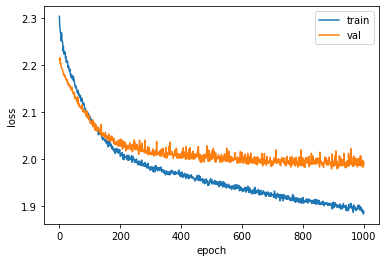

In [118]:
plt.plot(range(epochs), loss["train"], label="train")
plt.plot(range(epochs), loss["val"], label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

In [68]:
for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()  # Clear the gradients
    
    outputs = net(inputs)  # Forward pass
    loss = criterion(outputs, labels)  # Calculate the loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update the weights
    
    train_loss += loss.item()
    print(outputs)
    _, predicted = outputs.max(1)
    labels.size(0)
    predicted.eq(labels).sum().item()
    
    break

tensor([[ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 0.2209,  0.5916,  0.4400,  0.1702, -1.5980],
        [ 